In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [21]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,5000000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,5000000), pdf
end

CALCPDF (generic function with 1 method)

In [22]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.0
tspan = (0.0, 100000.0)

(0.0, 100000.0)

In [23]:
k_space = range(0.050, 0.056, length = 100)
length(k_space)

100

In [24]:
spectrum_array = zeros(6, length(k_space))
condition_array = zeros(6, length(k_space))

EVA_array = zeros(length(k_space))

int(x) = floor(Int, x)

int (generic function with 1 method)

In [25]:
p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, 0.0]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
 -0.17
 -0.17
  0.0

In [26]:
for (i, k) in enumerate(k_space)
    
    if i == 1
        global u0 =  SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
        # SA[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1]
        # SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
    end
    
    println("Initial condition: $u0"); flush(stdout)
    println("index: $i");flush(stdout)
    println("k: $k"); flush(stdout)
    
    condition_array[:, i] = u0
    
    p = SA[a, b, c, d,
        s, xr, r, I, xv, k, k, 0]
    println("p: $p");flush(stdout)
    prob = ODEProblem(HR, u0, tspan, p)
    sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
   
    ds_HR = ContinuousDynamicalSystem(HR, u0, p )
    spectrum = lyapunovspectrum(ds_HR, tspan[2]; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
    spectrum_array[1:6, i] = spectrum[1:6]
    println("Spectrum: ", spectrum_array[1:6, i]); flush(stdout)
    
    u0 = sol[end]
    
    println("Last point: ", u0); flush(stdout)
    
    xsum = sol[1,:] + sol[4,:]
    println("x_sum before truncate length: ", length(xsum)); flush(stdout)
    xsum = xsum[floor(Int, length(xsum) / 2):end ]
    println("x_sum after truncate length: ", length(xsum)); flush(stdout)
    
    """Hs = Statistics.mean(xsum) + 6 * Statistics.std(xsum)
    counts = xsum[xsum.>=Hs]
    counts = length(counts)
    EVA_array[i]  = counts
    
    println("counts: ", counts)"""
    
    println(">>>>>>>>>>>>>>>")
    println("")
end

Initial condition: [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
index: 1
k: 0.05
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.05, 0.0]
Spectrum: [7.295771538953988e-5, -0.000498606217734998, -0.009205063470488556, -0.025598693102574076, -7.356627385989643, -10.236434330980387]
Last point: [-0.9388549068969583, -3.6451959856898397, 3.82084448750515, -0.39625218773408294, -0.6546823327959298, 3.634205458671196]
x_sum before truncate length: 1260486
x_sum after truncate length: 630244
>>>>>>>>>>>>>>>

Initial condition: [-0.9388549068969583, -3.6451959856898397, 3.82084448750515, -0.39625218773408294, -0.6546823327959298, 3.634205458671196]
index: 2
k: 0.05006060606060606
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05006060606060606, 0.05006060606060606, 0.0]
Spectrum: [2.1603406017276965e-5, -0.0004393018929614626, -0.009265335564382826, -0.025698186796293716, -7.3575887376055915, -10.244643616517136]
Last point: [-1.0582334127585358, -4.9083743241047815, 3.603984675388581, -1

index: 14
k: 0.050787878787878785
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.050787878787878785, 0.050787878787878785, 0.0]
Spectrum: [8.827103631976825e-6, -0.00025320438609452135, -0.008895614559152786, -0.02568082555482444, -7.364172742698532, -10.239032744668888]
Last point: [-1.2501689742979973, -6.834016171067097, 3.805530922991058, -1.233565664096558, -6.524760607082619, 3.922765896097607]
x_sum before truncate length: 1260869
x_sum after truncate length: 630436
>>>>>>>>>>>>>>>

Initial condition: [-1.2501689742979973, -6.834016171067097, 3.805530922991058, -1.233565664096558, -6.524760607082619, 3.922765896097607]
index: 15
k: 0.05084848484848485
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05084848484848485, 0.05084848484848485, 0.0]
Spectrum: [6.691887569324732e-6, -0.00028154426823198073, -0.008852747993262279, -0.025645536098465004, -7.365789914462397, -10.239102176309997]
Last point: [-1.251708207549627, -6.786881551823682, 3.8768205628000767, -1.20705325

index: 27
k: 0.05157575757575757
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05157575757575757, 0.05157575757575757, 0.0]
Spectrum: [3.303553955643793e-5, -0.00010157208275402004, -0.00849018279260536, -0.02566374658080112, -7.372959526858537, -10.233327949715797]
Last point: [-1.1603696989824066, -5.930981135878021, 3.6516326912146844, -1.2223664408952855, -6.551773922700988, 3.748946494561981]
x_sum before truncate length: 1261758
x_sum after truncate length: 630880
>>>>>>>>>>>>>>>

Initial condition: [-1.1603696989824066, -5.930981135878021, 3.6516326912146844, -1.2223664408952855, -6.551773922700988, 3.748946494561981]
index: 28
k: 0.05163636363636363
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05163636363636363, 0.05163636363636363, 0.0]
Spectrum: [2.044513323009611e-5, -5.15711647990986e-5, -0.008489235768303014, -0.025646829949272282, -7.374502337309019, -10.23331784459057]
Last point: [-1.017316241297965, -4.525588509132283, 3.593850961303919, -1.1530142803886

index: 40
k: 0.05236363636363636
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05236363636363636, 0.05236363636363636, 0.0]
Spectrum: [8.670892779838709e-5, -0.00025166788248003774, -0.008227932321210904, -0.02872465565929135, -7.3913193439404665, -10.212337889308463]
Last point: [-0.7699039933675641, -2.1699779042768146, 4.033721767796108, -0.9349431023357867, -3.4061204636870785, 4.029297089852609]
x_sum before truncate length: 1260864
x_sum after truncate length: 630433
>>>>>>>>>>>>>>>

Initial condition: [-0.7699039933675641, -2.1699779042768146, 4.033721767796108, -0.9349431023357867, -3.4061204636870785, 4.029297089852609]
index: 41
k: 0.05242424242424242
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05242424242424242, 0.05242424242424242, 0.0]
Spectrum: [5.2171892455622396e-5, -0.0002778748459753608, -0.008263515671185627, -0.029273099465574715, -7.392838639740714, -10.209665614031168]
Last point: [-0.42529822689335567, -0.40810881581895564, 4.074454270951306, -0.8

index: 53
k: 0.05315151515151515
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05315151515151515, 0.05315151515151515, 0.0]
Spectrum: [0.0031673223103779314, 0.0007520008495383128, -0.006955580173576529, -0.021190089638769, -7.375607044582281, -10.160933516433966]
Last point: [-1.1106628285760225, -4.983856469038082, 4.103180246528403, -1.1991308887989258, -5.972694215694726, 4.082487123952289]
x_sum before truncate length: 1246053
x_sum after truncate length: 623028
>>>>>>>>>>>>>>>

Initial condition: [-1.1106628285760225, -4.983856469038082, 4.103180246528403, -1.1991308887989258, -5.972694215694726, 4.082487123952289]
index: 54
k: 0.05321212121212121
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05321212121212121, 0.05321212121212121, 0.0]
Spectrum: [0.00402017562090934, 0.0015855894962856585, -0.006176108074897043, -0.02105180113781249, -7.353162732370862, -10.162669958705068]
Last point: [-0.7890197175531425, -2.4164182000710968, 3.8993944890126264, -0.71171236634957

index: 66
k: 0.05393939393939394
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05393939393939394, 0.05393939393939394, 0.0]
Spectrum: [0.008601645322322255, 0.003809095099128392, -0.0024791772212012487, -0.011802217475964279, -7.265318426429731, -10.153129917135878]
Last point: [-1.0231908774122656, -4.092050761641742, 4.134063882559209, -0.9694383663650535, -3.6700832590457306, 4.0628889942314625]
x_sum before truncate length: 1224834
x_sum after truncate length: 612418
>>>>>>>>>>>>>>>

Initial condition: [-1.0231908774122656, -4.092050761641742, 4.134063882559209, -0.9694383663650535, -3.6700832590457306, 4.0628889942314625]
index: 67
k: 0.054
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.054, 0.054, 0.0]
Spectrum: [0.011010500735003516, 0.0047832564954561965, -0.0009602222218827518, -0.007380684647902484, -7.195403435660449, -10.155089896548713]
Last point: [-0.9731556354599884, -3.495410320737865, 4.298509475305935, -0.5842837245257586, -1.1788649827752704, 3.95020255

index: 79
k: 0.05472727272727273
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05472727272727273, 0.05472727272727273, 0.0]
Spectrum: [0.010668113745656373, 0.0032405388470309266, -0.0009426479735747567, -0.007893780479407371, -7.223250633806487, -10.163138311814283]
Last point: [-1.1093624816486372, -5.369504536274012, 3.668371947387332, -0.6728843776244733, -1.629368777243065, 3.970264198581589]
x_sum before truncate length: 1222430
x_sum after truncate length: 611216
>>>>>>>>>>>>>>>

Initial condition: [-1.1093624816486372, -5.369504536274012, 3.668371947387332, -0.6728843776244733, -1.629368777243065, 3.970264198581589]
index: 80
k: 0.05478787878787879
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05478787878787879, 0.05478787878787879, 0.0]
Spectrum: [0.011581655943822045, 0.0039209367802043975, -0.00011062901488008805, -0.0068207523111470224, -7.185687603729046, -10.175275562528853]
Last point: [-0.38462526929338686, -0.25933657653897196, 4.087138388298876, -0.85987

index: 92
k: 0.05551515151515152
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05551515151515152, 0.05551515151515152, 0.0]
Spectrum: [0.011594541046376357, 0.004692321366955315, -0.00016005776745717885, -0.00713705387022472, -7.199549924816398, -10.154368879869823]
Last point: [-1.0304457142944055, -4.579865379972943, 3.670430221486963, -1.1292466684868951, -5.6730022624381515, 3.5638450419572067]
x_sum before truncate length: 1223118
x_sum after truncate length: 611560
>>>>>>>>>>>>>>>

Initial condition: [-1.0304457142944055, -4.579865379972943, 3.670430221486963, -1.1292466684868951, -5.6730022624381515, 3.5638450419572067]
index: 93
k: 0.05557575757575758
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05557575757575758, 0.05557575757575758, 0.0]
Spectrum: [0.009483612959550412, 0.0019601258904948394, -0.0010534496554113681, -0.0112955975395433, -7.273519850271724, -10.151778692256194]
Last point: [-0.9951879513119485, -3.7972801034444945, 4.175585240889663, -1.10528564

In [7]:
using CairoMakie

In [8]:
CairoMakie.activate!()

In [95]:
using JLD

In [96]:
# save("spectrum_orbitdiagram_full.jld", "data", spectrum_array)

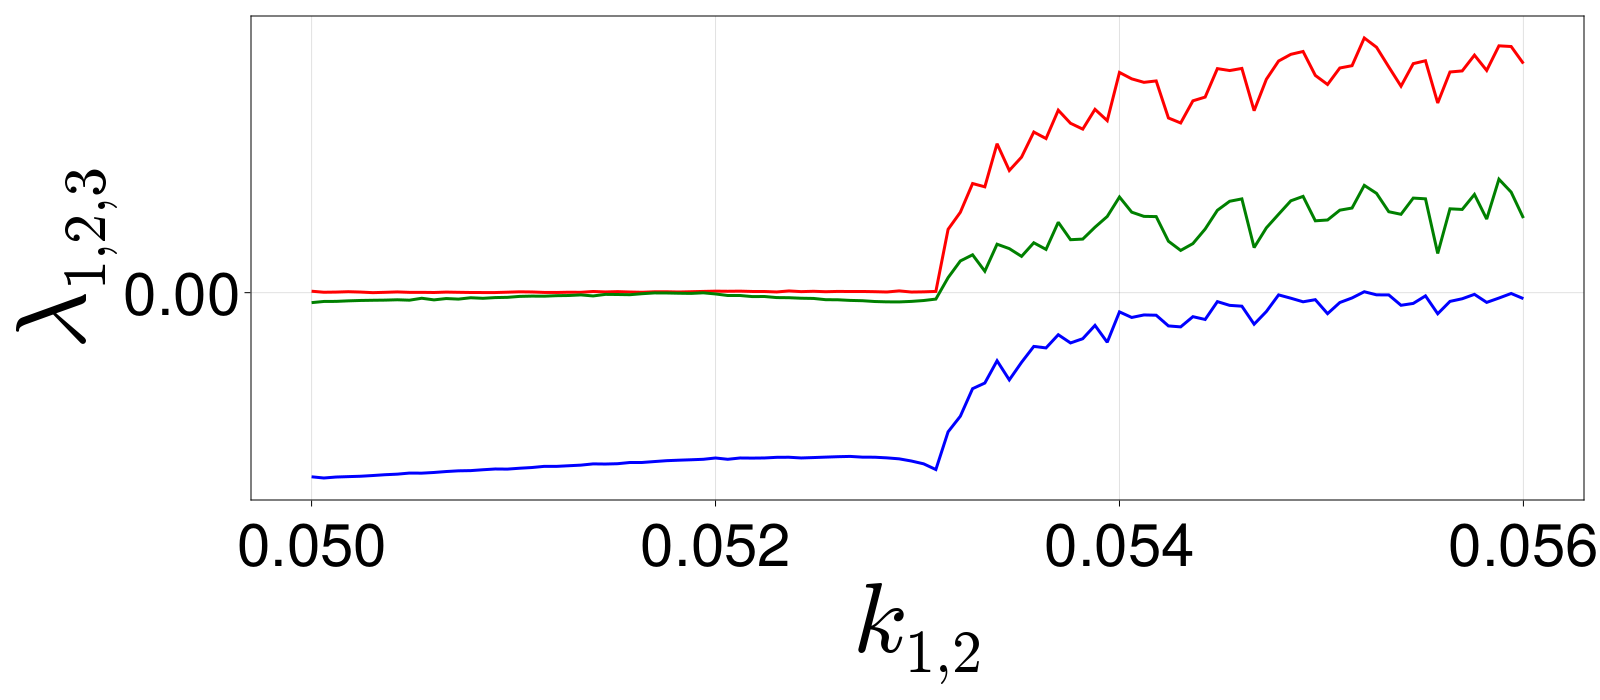

In [34]:
# L1
ticks = range(0.05, 0.056, length = 4)
f = Figure(resolution = (1600, 700), fontsize = 20)
ax = Axis(f[1, 1], xlabel = L"k_{1, 2}", ylabel = L"\lambda_{1, 2, 3}",
xlabelsize = 100, ylabelsize = 100,
                xticklabelsize = 60, yticklabelsize = 60, xticks = ticks, yticks = yticks  )


lines!(ax, k_space, spectrum_array[1, :], linewidth = 3.0, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 3.0, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 3.0, color = "blue")
save("LE_orbit_zoom.eps", f)
f

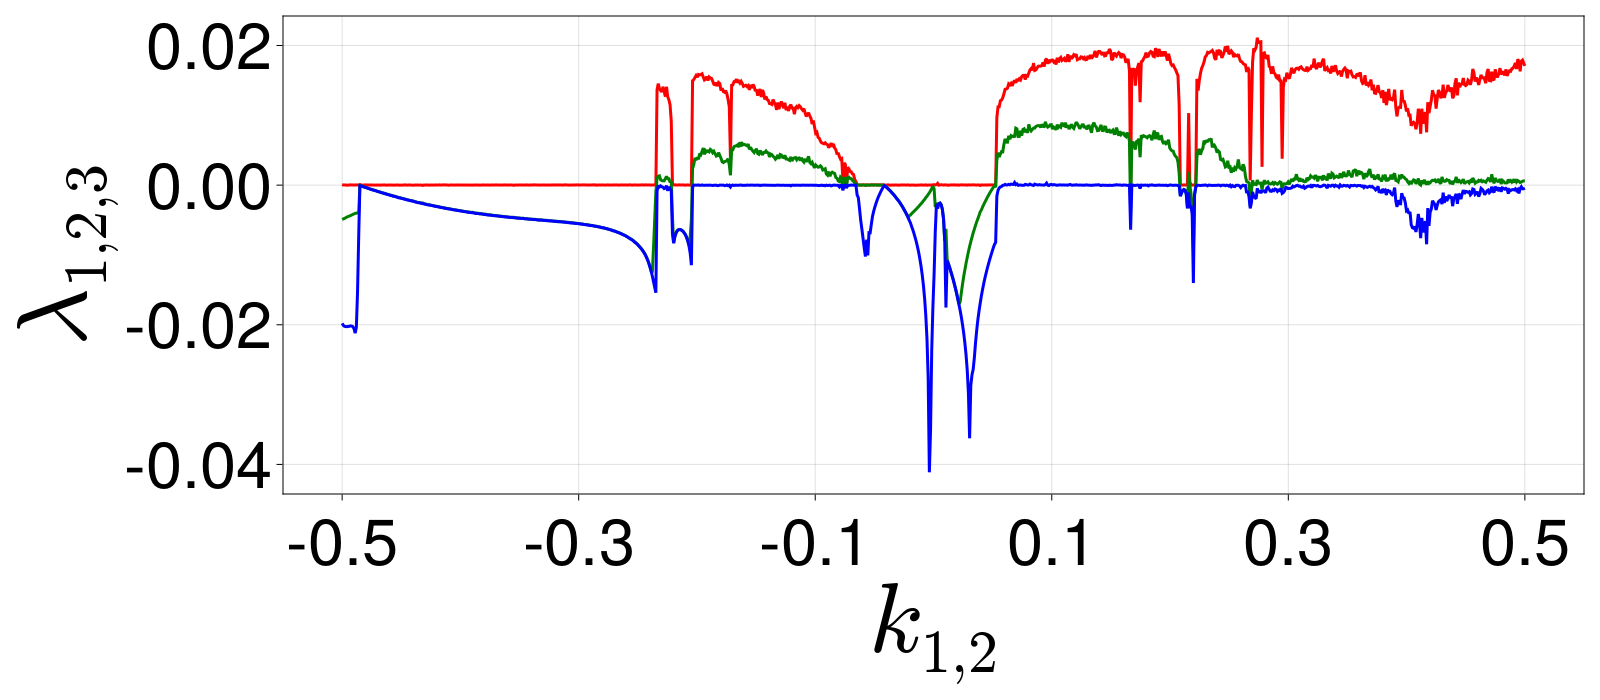

In [16]:
# L1
ticks = range(-0.5, 0.5, length = 6)
yticks = range(-0.04, 0.02, length = 4)
f = Figure(resolution = (1600, 700), fontsize = 20)
ax = Axis(f[1, 1], xlabel = L"k_{1, 2}", ylabel = L"\lambda_{1, 2, 3}",
xlabelsize = 100, ylabelsize = 100,
                xticklabelsize = 65, yticklabelsize = 65, xticks = ticks, yticks = yticks  )


lines!(ax, k_space, spectrum_array[1, :], linewidth = 3.0, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 3.0, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 3.0, color = "blue")
save("LE_orbit_full.eps", f)
f

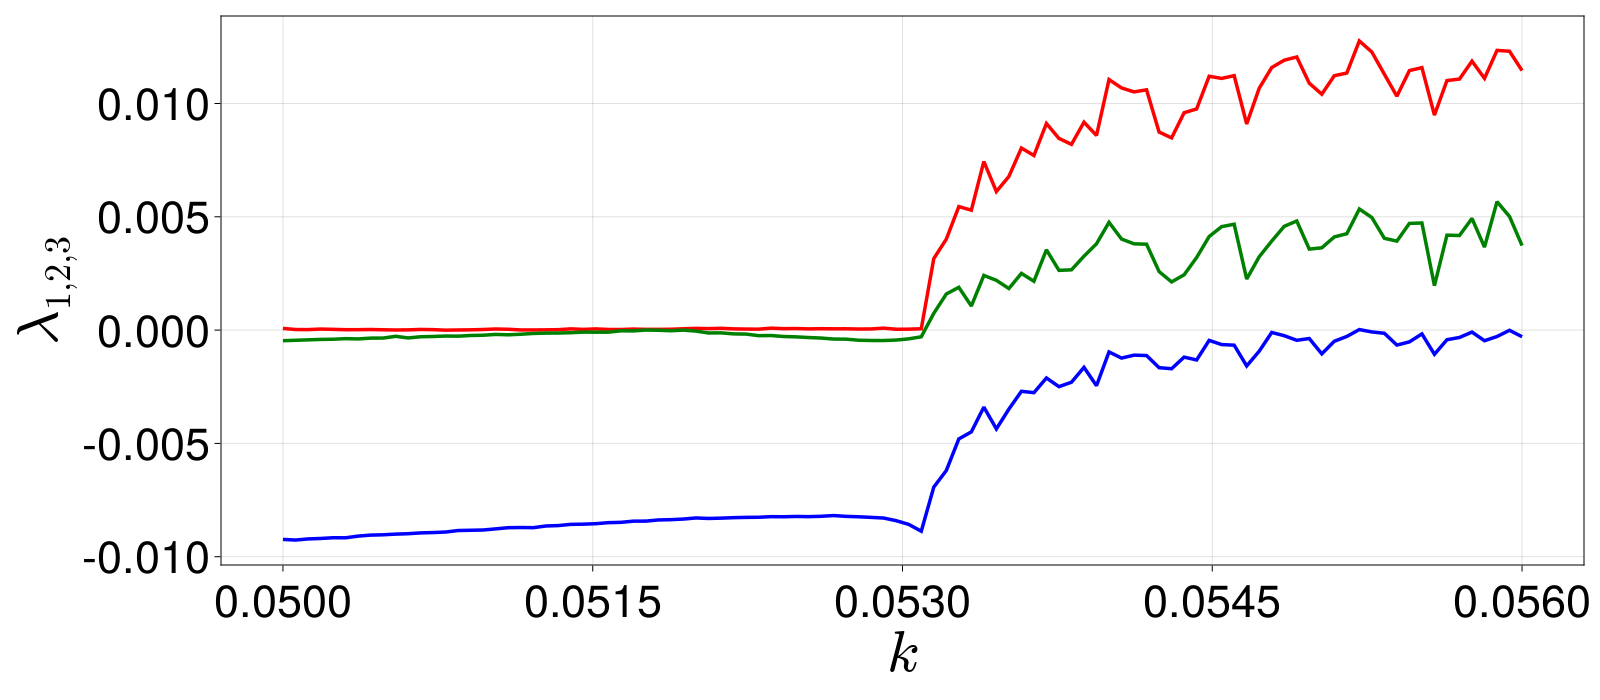

In [85]:
# L1
ticks = range(0.05, 0.056, length = 5)
f = Figure(resolution = (1600, 700), fontsize = 20)
ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}",
xlabelsize = 60, ylabelsize = 60,
                xticklabelsize = 45, yticklabelsize = 45, xticks = ticks  )


lines!(ax, k_space, spectrum_array[1, :], linewidth = 3.5, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 3.5, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 3.5, color = "blue")
save("LE_orbit_zoom.eps", f)
f

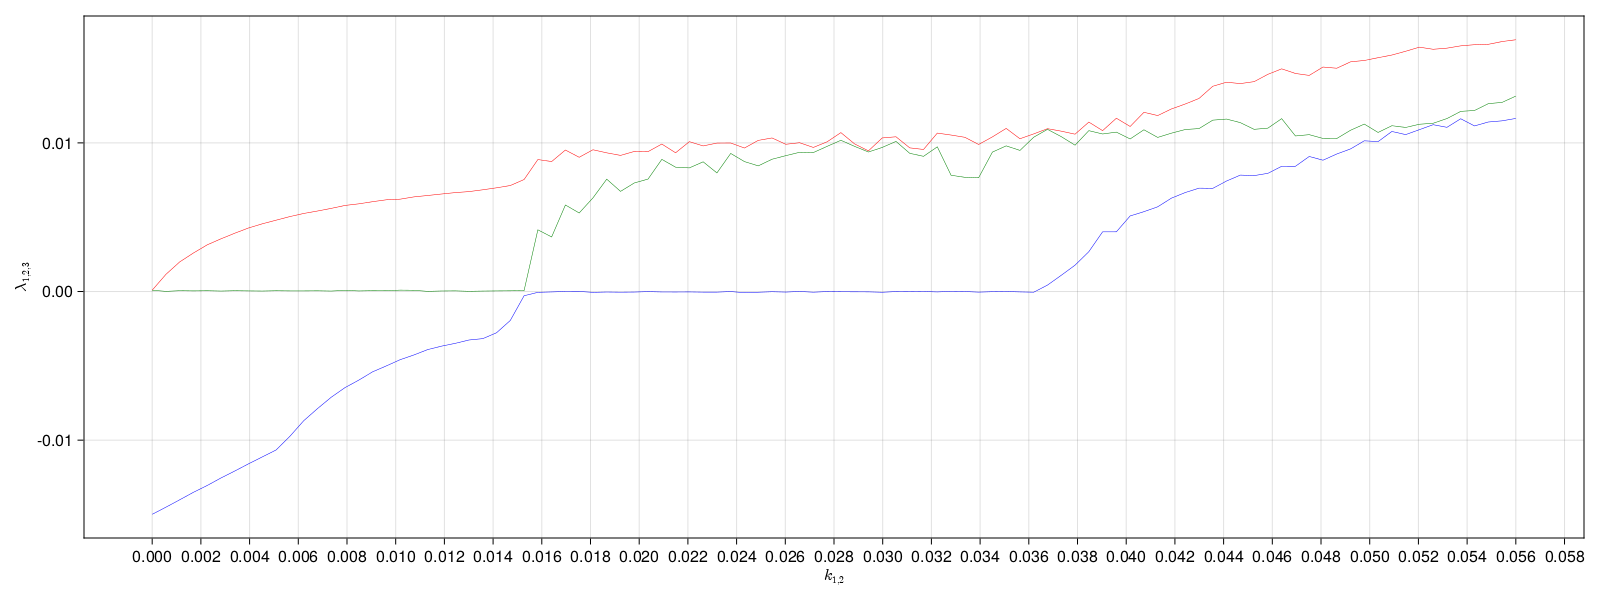

In [49]:
# L2
xticks = range(0.0, 0.56, step = 0.002)
f = Figure(resolution = (1600, 600) )
ax = Axis(f[1, 1], xlabel = L"k_{1, 2}", ylabel = L"\lambda_{1, 2, 3}",
xticks = xticks)


lines!(ax, k_space, spectrum_array[1, :], linewidth = 0.5, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 0.5, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 0.5, color = "blue")
f